<a href="https://colab.research.google.com/github/laurenneal/capstone-visual-neuroscience/blob/Dylan/Demo_Caiman_Stripped_Working_Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The demo_pipeline file we've been working with uses some of the more advanced features of caiman which I think are throwing me off. 

This notebook is intended to implement a more stripped down version of the caiman pipeline with the goal of understanding the functions better and potentially being a platform to write our wrapper around for the parameter gridsearch

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install CaImAn - takes around 2 minutes
!git clone https://github.com/flatironinstitute/CaImAn.git
%cd '/content/CaImAn/'
!pip install -e .

# Install caiman dependencies (&> /dev/null will suppress the hundreds of printed lines in the output)
!pip install -r requirements.txt &> /dev/null

#import other dependencies
import cv2
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import imageio

#IMPORTANT! Newer versions of h5py will cause errors when saving results
!pip install h5py==2.10.0
import h5py

#Set up caiman
!python setup.py build_ext -i

#Other file setup
!python caimanmanager.py install --inplace

#Caiman imports
import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf import params as params
from caiman.utils.utils import download_demo
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
from caiman.summary_images import local_correlations_movie_offline
from scipy.ndimage import center_of_mass
from IPython.display import display, clear_output

Cloning into 'CaImAn'...
remote: Enumerating objects: 24916, done.
remote: Counting objects: 100% (851/851), done.
remote: Compressing objects: 100% (421/421), done.
remote: Total 24916 (delta 475), reused 739 (delta 414), pack-reused 24065
Receiving objects: 100% (24916/24916), 518.52 MiB | 22.59 MiB/s, done.
Resolving deltas: 100% (16688/16688), done.
Checking out files: 100% (317/317), done.
/content/CaImAn
Obtaining file:///content/CaImAn
  Running setup.py develop for caiman
     |████████████████████████████████| 2.9 MB 4.2 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
running build_ext
Installed /root/caiman_data


In [76]:
#Using h5py to open and explore a test raw stack
#paths into google drive to a random pre-motion correction movie

fnames = ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/210815_0/210815_0_1_stackRaw_mc_mix1_syt_.mat']
subfolder = 'stackRaw_mc'

stackRaw = h5py.File(fnames[0], 'r+')


In [77]:
#save movie array as a variable to check a few frames
mov = np.array(stackRaw[subfolder])

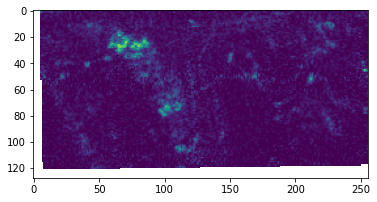

In [78]:
#numpy function to flip the x and y for whole movie array
flip = np.transpose(mov, axes = (0,2,1))
#show the 500th frame
plt.imshow(flip[500])

In [90]:
#save the flipped file back to an h5 file to test with
#This is just for development so we don't have to wait for processing times

#just the first 1000 frames
flip = flip[:1000]

#motion corrected files have many nans which I think breaks Caiman, pleace nan with 0
flip = np.nan_to_num(flip, 0)


h5f = h5py.File('../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/subset_stackRaw_mc.h5', 'w')
h5f.create_dataset(subfolder, data=flip[:500])

h5f.close()

#point the fnames param at the new location
fnames = ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/subset_stackRaw_mc.h5']


In [91]:
#start a cluster for parallel processing (if a cluster already exists it will be closed and a new session will be opened)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

#create parameters object
opts = params.CNMFParams()

In [117]:
# set up some parameters for extraction
#fnames = path to video file, set above
                        # file(s) to be analyzed
is_patches = False       # flag for processing in patches or not - CONFIRMED FROM CARL
fr = 20                 # approximate frame rate of data - CONFIRMED FPS
decay_time = .4        # length of transient - CONFIRMED APPROPRIATE FOR OUR INDICATOR GCaMP6f
dims = [128, 256]

if is_patches:          # PROCESS IN PATCHES AND THEN COMBINE - not used
    rf = 25             # half size of each patch - not used
    stride = 5          # overlap between patches - not used
    K = 3               # number of components in each patch - not used
else:                   # PROCESS THE WHOLE FOV AT ONCE
    rf = None           # setting these parameters to None - CONFIRMED
    stride = None       # will run CNMF on the whole FOV - CONFIRMED
    K = 20              # number of neurons expected (in the whole FOV) - TUNE

gSig = [4, 4]           # expected half size of neurons - TUNE
merge_thresh = 0.9     # merging threshold, max correlation allowed - TUNE
p = 0                   # order of the autoregressive system - From carl's code, probably should be 1
gnb = 2                 # global background order - TUNE

var_name_hdf5 = subfolder #variable to path caiman into the subfolder within our mat files

opts.set('data', {'fnames': fnames,
                   'fr': fr,
                   'decay_time': decay_time,
                   'dims': dims,
                   'rf': rf,
                   'stride': stride,
                   'K': K,
                   'gSig': gSig,
                   'merge_thr': merge_thresh,
                   'p': p,
                   'nb': gnb
                  })




In [118]:
# %% COMPONENT EVALUATION
# the components are evaluated in three ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient
#   c) each shape passes a CNN based classifier (this will pick up only neurons
#           and filter out active processes)


#Not sure if these should be tuned or not

min_SNR = 2.5      # peak SNR for accepted components (if above this, acept)
rval_thr = 0.9     # space correlation threshold (if above this, accept)
use_cnn = True      # use the CNN classifier
min_cnn_thr = 0.9  # if cnn classifier predicts below this value, reject
cnn_lowest = 0.1 # neurons with cnn probability lower than this value are rejected

opts.set('quality', {'min_SNR': min_SNR,
                                'rval_thr': rval_thr,
                                'use_cnn': use_cnn,
                                'min_cnn_thr': min_cnn_thr,
                                'cnn_lowest': cnn_lowest})

In [119]:
#THIS FUCKING LINE IS ALL IT TOOK
#THE MOTION PARAMS DOES NOT PULL IN THE VAR NAME BY DEFAULT
#NEEDS TO BE MANUALLY INJECTED SO IT GETS PULLED INTO MOTION CORRECT WITH THE REST

opts.motion['var_name_hdf5'] = subfolder
opts.data['var_name_hdf5'] = subfolder

#Also adjust preprocessing to allow nans
#opts.preprocess['check_nan'] = False

The 2 lines below initiate and then run the caiman motion correction, deconvolution, and ROI evaluation by calling the fit_file function.

Pasting the source code of fit_file here for transparency: 


def fit_file(self, motion_correct=False, indices=None, include_eval=False):

        This method packages the analysis pipeline (motion correction, memory
        mapping, patch based CNMF processing and component evaluation) in a
        single method that can be called on a specific (sequence of) file(s).
        It is assumed that the CNMF object already contains a params object
        where the location of the files and all the relevant parameters have
        been specified. The method will perform the last step, i.e. component
        evaluation, if the flag "include_eval" is set to `True`.

        Args:
            motion_correct (bool)
                flag for performing motion correction
            indices (list of slice objects)
                perform analysis only on a part of the FOV
            include_eval (bool)
                flag for performing component evaluation
        Returns:
            cnmf object with the current estimates


        if indices is None:
            indices = (slice(None), slice(None))
        fnames = self.params.get('data', 'fnames')
        if os.path.exists(fnames[0]):
            _, extension = os.path.splitext(fnames[0])[:2]
            extension = extension.lower()
        else:
            logging.warning("Error: File not found, with file list:\n" + fnames[0])
            raise Exception('File not found!')

        base_name = pathlib.Path(fnames[0]).stem + "_memmap_"
        if extension == '.mmap':
            fname_new = fnames[0]
            Yr, dims, T = mmapping.load_memmap(fnames[0])
            if np.isfortran(Yr):
                raise Exception('The file should be in C order (see save_memmap function)')
        else:
            if motion_correct:
                mc = MotionCorrect(fnames, dview=self.dview, **self.params.motion)
                mc.motion_correct(save_movie=True)
                fname_mc = mc.fname_tot_els if self.params.motion['pw_rigid'] else mc.fname_tot_rig
                if self.params.get('motion', 'pw_rigid'):
                    b0 = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                            np.max(np.abs(mc.y_shifts_els)))).astype(np.int)
                    self.estimates.shifts = [mc.x_shifts_els, mc.y_shifts_els]
                else:
                    b0 = np.ceil(np.max(np.abs(mc.shifts_rig))).astype(np.int)
                    self.estimates.shifts = mc.shifts_rig
                # TODO - b0 is currently direction inspecific, which can cause
                # sub-optimal behavior. See
                # https://github.com/flatironinstitute/CaImAn/pull/618#discussion_r313960370
                # for further details.
                # b0 = 0 if self.params.get('motion', 'border_nan') is 'copy' else 0
                b0 = 0
                fname_new = mmapping.save_memmap(fname_mc, base_name=base_name, order='C',
                                                 border_to_0=b0)
            else:
                fname_new = mmapping.save_memmap(fnames, base_name=base_name, order='C')
            Yr, dims, T = mmapping.load_memmap(fname_new)

        images = np.reshape(Yr.T, [T] + list(dims), order='F')
        self.mmap_file = fname_new
        if not include_eval:
            return self.fit(images, indices=indices)

        fit_cnm = self.fit(images, indices=indices)
        Cn = summary_images.local_correlations(images[::max(T//1000, 1)], swap_dim=False)
        Cn[np.isnan(Cn)] = 0
        fit_cnm.save(fname_new[:-5]+'_init.hdf5')
        #fit_cnm.params.change_params({'p': self.params.get('preprocess', 'p')})
        # RE-RUN seeded CNMF on accepted patches to refine and perform deconvolution
        cnm2 = fit_cnm.refit(images, dview=self.dview)
        cnm2.estimates.evaluate_components(images, cnm2.params, dview=self.dview)
        # update object with selected components
        #cnm2.estimates.select_components(use_object=True)
        # Extract DF/F values
        cnm2.estimates.detrend_df_f(quantileMin=8, frames_window=250)
        cnm2.estimates.Cn = Cn
        cnm2.save(cnm2.mmap_file[:-4] + 'hdf5')

        cluster.stop_server(dview=self.dview)
        log_files = glob.glob('*_LOG_*')
        for log_file in log_files:
            os.remove(log_file)

        return cnm2


In [120]:
# %% Now RUN CaImAn Batch (CNMF)
cnm = cnmf.CNMF(n_processes, params=opts, dview=dview)
cnm = cnm.fit_file(motion_correct = False, include_eval=True)

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


USING MODEL:/root/caiman_data/model/cnn_model.json
1/1 [==============================] - 0s 162ms/step


These cells only work if the fit function has gone through without errors

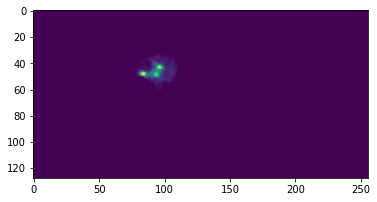

In [121]:
import matplotlib.pyplot as plt
dims = [128,256]
#5th component
plt.figure() 
plt.imshow(np.reshape(cnm.estimates.A[:,4].toarray(), dims, order='F'))

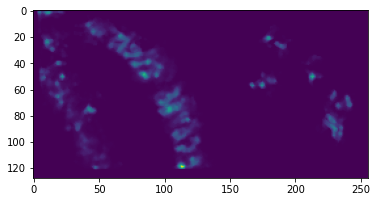

In [122]:
#visualize all roi's identified
roiimg = np.zeros((32768,1))

for i in range(cnm.estimates.A.shape[1]):
  roiimg = roiimg+cnm.estimates.A[:,i]

plt.figure()
plt.imshow(np.reshape(roiimg, dims, order="F"))

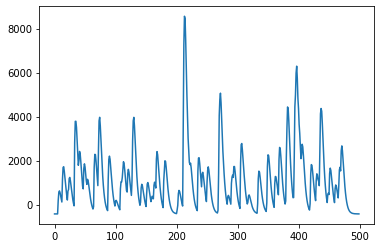

In [123]:
#deconvolved trace for 5th component
plt.figure() 
plt.plot(cnm.estimates.C[4])

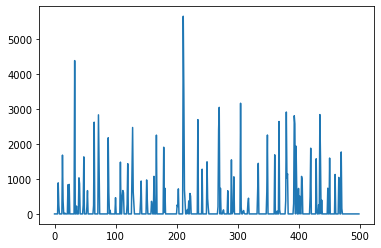

In [124]:
#inferred spikes for 5th component
plt.figure() 
plt.plot(cnm.estimates.S[4])

In [125]:
#returns a list of our binary masks
M = cnm.estimates.A > 0
masks = [np.reshape(M[:,i].toarray(), dims, order='F') for i in range(M.shape[1])]

In [126]:
M.shape

(32768, 27)

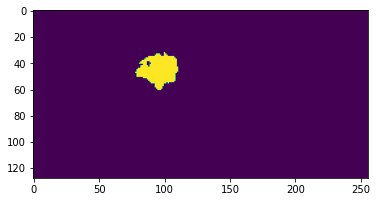

In [127]:
#plot mask for 3rd ROI
plt.imshow(np.reshape(masks[4], dims, order='F'))

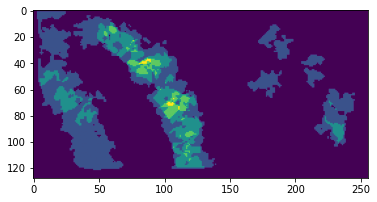

In [128]:
#visualize all masks
img = np.zeros((32768,1))

for i in range(M.shape[1]):
  img = img+M[:,i]

plt.figure()
plt.imshow(np.reshape(img, dims, order="F"))

In [129]:
# %% STOP CLUSTER and clean up log files
cm.stop_server(dview=dview)

## Reading in and reformatting Carl's masks

In [130]:
#path to manual ROI file provided by Carl
!ls ../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/manualROIs_fixed/210815_0_1_manualROIs_mix1_syt.mat


../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/manualROIs_fixed/210815_0_1_manualROIs_mix1_syt.mat


In [131]:
#masks for validation
g = h5py.File('../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/manualROIs_fixed/210815_0_1_manualROIs_mix1_syt.mat', 'r')

#transpose the matrix and save to an array A
mask_A = g['bwMaskStack'][:].T

#rearrange the dimensions and show the new shape
mask_A = mask_A.transpose(1,0,2)

#reshape to 2D, first dimension is 128*256 (32768), 2nd dimension is the # of ROI's
mask_A = mask_A.reshape((mask_A.shape[1]*mask_A.shape[0]), mask_A.shape[2])

#convert the values from 0/1 to boolean False/True
mask_A = np.array(mask_A, dtype=bool)

#show the shape of the matris that holds the roi masks
mask_A.shape

(32768, 15)

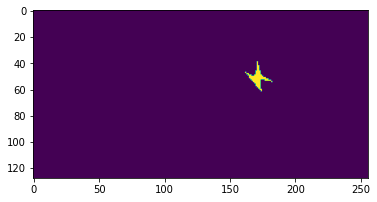

In [132]:
#Show the unique looking ROI to confirm we're not distorting ROIs
plt.imshow(np.reshape(mask_A[:,11], dims, order='F'))

In [133]:
#make the matrix sparse before visualizing, otherwise this crashes
import scipy.sparse as sparse
A_sparse = sparse.csc_matrix(mask_A)

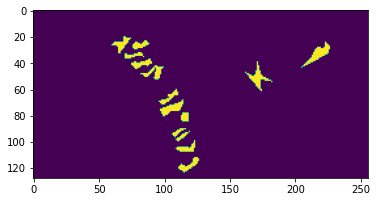

In [134]:
#visualize all roi masks
maskimg = np.zeros((32768,1))

for i in range(A_sparse.shape[1]):
  maskimg = maskimg+A_sparse[:,i]

plt.figure()
plt.imshow(np.reshape(maskimg, dims, order="F"))

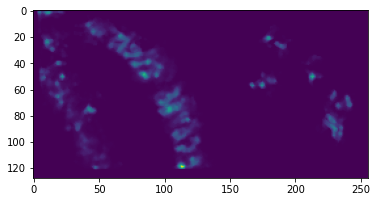

In [135]:
#For comparison visualize all rois identified
img = np.zeros((32768,1))

for i in range(cnm.estimates.A.shape[1]):
  img = img+cnm.estimates.A[:,i]

plt.figure()
plt.imshow(np.reshape(img, dims, order="F"))

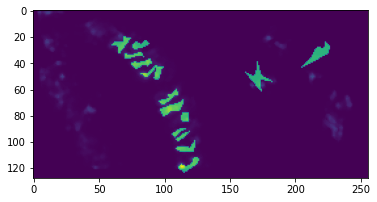

In [136]:
#overlay carl's masks on the roi's identified to validate alignment
overlay = roiimg+maskimg
plt.figure()
plt.imshow(np.reshape(overlay, dims, order="F"))

## Run Seeded CNMF using Carl's Mask

In [137]:
#Seeded CNMF only works when seeded using mmap
import pathlib

#create memmory map location for the original movie
fname_new = cm.save_memmap(fnames, base_name=pathlib.Path(fnames[0]).stem + "_memmap_", order='C')

#read data from mmap location
Yr, dims, T = cm.load_memmap(fname_new)

# load frames in python format (T x X x Y)
mov = np.reshape(Yr.T, [T] + list(dims), order='F')

In [138]:
#For seeded CNMF, need to adjust some params
rf = None
only_init = False

opts.patch['only_init'] = only_init
opts.patch['rf'] = rf

In [139]:
#%% restart cluster to clean up memory
cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

In [140]:
#Initialize a new cnmf object and pass in our masks as the "Ain" param
#"Ain" is A-in, meaning the A matrix holding the spatial footprints of the roi's
cnm_seeded = cnmf.CNMF(n_processes, params=opts, dview=dview, Ain=mask_A)
cnm_seeded.fit(mov)

spatial support for each components given by the user


/usr/local/lib/python3.7/dist-packages/scipy/sparse/dia.py:300: RuntimeWarning: divide by zero encountered in remainder
  c = np.arange(num_rows, dtype=np.intc) - (offsets % max_dim)[:, None]


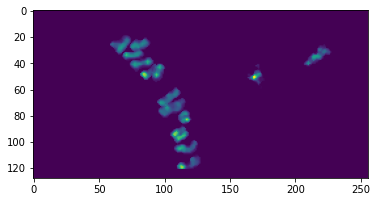

In [154]:
#visualize all roi's identified after seeding
roiimg = np.zeros((32768,1))

for i in range(cnm_seeded.estimates.A.shape[1]):
  roiimg = roiimg+cnm_seeded.estimates.A[:,i]

plt.figure()
plt.imshow(np.reshape(roiimg, dims, order="F"))

## Validation and scoring

In [141]:
#Try running register_ROIs and see what happens
matched_ROIs1, matched_ROIs2, non_matched1, non_matched2, performance, A2 = cm.base.rois.register_ROIs(cnm_seeded.estimates.A, cnm.estimates.A, dims=dims)

#return matching performance
performance

{'accuracy': 0.13513513513513514,
 'f1_score': 0.23809523809523808,
 'precision': 0.18518518518518517,
 'recall': 0.3333333333333333}